# ROB 498: Robot Learning for Planning and Control
# Assignment 2: Introduction to Optimal Control

## Colab Setup

In [32]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW2 folder, then 'ROB498/HW2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498/HW2'

### Setup Code

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw2.ipynb', 'base_env.py', 'cartpole_env.py', 'panda_env.py', 'linear_mpc.py', 'mppi_control.py']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

drive/My Drive/ROB498/HW2
All required files are found :)


In [36]:
# Install missing required packages
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
!pip install control

In [37]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

## Assignment Introduction

Due 2/19 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

## 1 - Cartpole Control (60 points)

In this section you will apply optimal control policies to control one of the classical control problems: the cartpole.


In [38]:
from cartpole_env import *

### Cartpole Setup
The cartpole is an example of an underactuated dynamical system. The goal is to mantain the pole location vertically while only being able to control the cart displacement via applying a linear force $F$.

Below you will see an example of the cartpole system we will be working with. This cartpole is simulated using PyBullet. Here, we will just apply random forces to the cart.


If you want to know more details about the pybullet simulation. You can check the `Cartpole` class in `cartpole_env.py`.

Run the cell below and observe that random actions result in behaviour far from stable.

  0%|          | 0/100 [00:00<?, ?it/s]

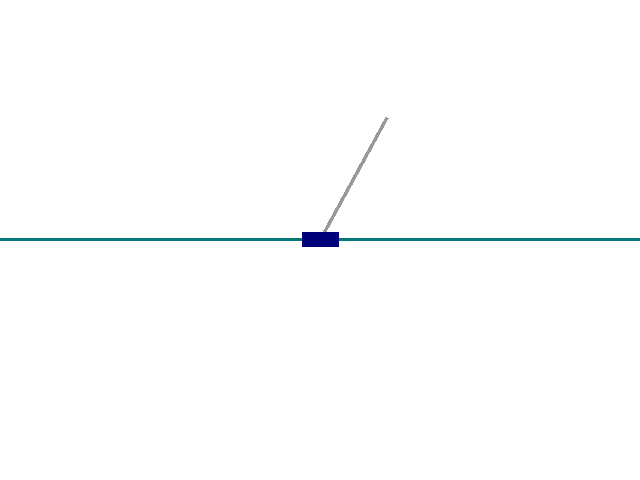

In [41]:
env = CartpoleEnv()
# env.reset(state = np.array([0.0, 0.5, 0.0, 0.0]))
env.reset(state = np.array([0.0, 0.5, 0.0, 0.0, 0.0, 0.0]))


frames=[] #frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.gif", frames, delay=10)
Image(filename="cartpole_example.gif")

## 1.1 Modelling & Linearization (14 points)

For this question you will implement an analytical dynamics function for the cartpole in PyTorch and explore different techniques for performing linearization.


### 1.1 a) PyTorch model of cartpole dynamics (6 points)
A diagram of the cartpole is shown below.

The state vector for the cartpole is $\mathbf{x} = [x, \theta, \dot{x}, \dot{\theta}]$. Here $x$ is the horizontal position of the cart, and $\theta$ is the angle of the pole. $\dot{x}, \theta$ are the velocities. The control $\mathbf{u}$ is the horizontal force $F$ in the $x$ direction. $\theta=0$ corresponds to the 'pole up' position.

<div>
<img src="https://drive.google.com/uc?export=view&id=1ERKgdsh8H7_0BnPaY1-CO9E_fYg7ASSX" width=300"/>
</div>

The equations of motions are as followed:

$$ \ddot{\theta} = \frac{g \sin \theta - \cos \theta \left [ \frac{F + m_p l \dot{\theta}^2 \sin \theta}{m_c + m_p} \right ]}{l \left[ \frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p} \right ]
}$$

$$ \ddot{x} = \frac{F + m_p l \left[ \dot{\theta}^2 \sin \theta - \ddot{\theta} \cos \theta \right]}{m_c + m_p}$$

Where

 * $m_p$ is the mass of the pendulum
 * $m_c$ is the mass of the cart
 * $l$ is the length of the pendulum
 * $g$ is the gravity

**For this question**:
- Complete the function `dynamics_analytic` in `cartpole_env.py` using the equations of motion above
- Your function should operate on batches of tensors - this will come in handy later!
- The relevant parameter values are already set inside `dynamics_analytic` - you do not need to modify them
- You can use `torch.chunk` to split the batched state of shape (B, 4) into 4 (B, 1) shape tensors representing the elements of the state. You can then compute the above accelerations using elementwise operations
- You should use compute the next state from accelerations and velocities using the following integration scheme:

$$ \dot{x}_{t+1} = \dot{x}_t + \Delta t \: \ddot{x}_t$$
$$ \dot{\theta}_{t+1} = \dot{\theta}_t + \Delta t \: \ddot{\theta}_t$$
$$ x_{t+1} = x_t + \Delta t \: \dot{x}_{t+1}$$
$$ \theta_{t+1} = \theta_t + \Delta t \: \dot{\theta}_{t+1}$$

- Note that the positions are updated with the new velocity rather than the old

                                                                                                                                                                                                   
**GRADING INFO**:

We will be checking the correctness of your dynamics implementation across different batch sizes.                                                                                                

In [45]:
## Let's test to see if your analytic dynamics matches the simulator

# first let's generate a random control sequence
T = 50
control_sequence = np.random.randn(T, 1)
start_state = np.array([1, 0.25, 0, 0, 0, 0])

# We use the simulator to simulate a trajectory
env = CartpoleEnv()
env.reset(start_state)
states_pybullet = np.zeros((T+1, 6))
states_pybullet[0] = start_state
for t in range(T):
    states_pybullet[t+1] = env.step(control_sequence[t])

# Now we will use your analytic dynamics to simulate a trajectory
states_analytic = torch.zeros(T+1, 1, 6) # Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic[0] = torch.from_numpy(start_state).reshape(1, 6)
for t in range(T):
    current_state = states_analytic[t]
    current_control = torch.from_numpy(control_sequence[t]).reshape(1, 1) # add batch dimension to control
    states_analytic[t+1] = dynamics_analytic(current_state, current_control)

# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 4).numpy()

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0][0].plot(states_analytic[:, 0], label='analytic')
axes[0][0].plot(states_pybullet[:, 0], '--', label='pybullet')

axes[0][0].title.set_text('x')
axes[0][1].plot(states_analytic[:, 1])
axes[0][1].plot(states_pybullet[:, 1], '--')

axes[0][1].title.set_text('theta')
axes[1][0].plot(states_analytic[:, 2])
axes[1][0].plot(states_pybullet[:, 2], '--')

axes[1][0].title.set_text('x_dot')
axes[1][1].plot(states_analytic[:, 3])
axes[1][1].plot(states_pybullet[:, 3], '--')

axes[1][1].title.set_text('theta_dot')
axes[0][0].legend()
plt.show()


ValueError: could not broadcast input array from shape (4,) into shape (6,)

In [ ]:
# Now let's test to see if your batching works as expected

# We should see that the analytic dynamics should produce approximately the same next states
# as the simulator. We can check this using a single call to your batched analytical dynamics function.

B = 4
states = 0.1 * torch.randn(B, 4)
actions = torch.randn(B, 1)

# first lets see what the pybullet dynamics are
print('Next states from simulator are: ')
for state, action in zip(states, actions):
    print(env.dynamics(state.numpy(), action.numpy()))

print('')
print('Batched next states from analytical dynamics are')
print(dynamics_analytic(states, actions))


### 1.1 b) Linearization (8 points)

In this section you will use two different techniques for linearizing the Cartpole dynamics around the fixed point $\mathbf{x}_r = [0, 0, 0, 0]^T, \mathbf{u}_r = [0]$.

When linearizing about a reference point $(\mathbf{x}_r, \mathbf{u}_r)$ the linearized dynamics are given by:

$$ \mathbf{x}_{t+1} = \mathbf{x}_r + A(\mathbf{x}_r, \mathbf{u}_r) (\mathbf{x}_t - \mathbf{x}_r) + B(\mathbf{x}_r, \mathbf{u}_r) (\mathbf{u}_t - \mathbf{u}_r)$$

For the linearization at $\mathbf{x}_r = [0, 0, 0, 0]^T, \mathbf{u}_r = [0]$. This simplifies to:

$$ \mathbf{x}_{t+1} = A(0,0)\mathbf{x}_t + B(0,0)\mathbf{u}_t$$



#### Part i)

- Complete the function `CartpoleEnv.linearize_numerical` in `cartpole.py`.
- Your should use the Symmetric Different Quotient formula from the lecture slides to compute the numerical derivatives.
- You can use the function `CartpoleEnv.dynamics` to evaluate the cartpole dynamics for a given state and control.

#### Part ii)
- Complete the function `linearize_pytorch` in `cartpole.py`.
- You should use your `dynamics_analytic` function from the previous question.
- `linearize_pytorch` expects tensors of shape (4,) and (1,). This is in contrast to `dynamics_analytic` which expects tensors of shape (B, 4) and (B, 1). You should use your `dynamics_analytic` function with B=1. You can add and remove dimensions with `torch.unsqueeze`, `torch.squeeze`, or `torch.reshape`


Note: You should notice that the $A$ and $B$ matrices produced by these functions are very similar, but not identical. They may be different by an order of approximately $1 \times 10^{-4}$

**GRADING INFO**:

We will check your linearization functions for the cartpole at different linearization points.

In [ ]:
# Linearization around
A_numerical, B_numerical = env.linearize_numerical(np.zeros(4), np.zeros(1))

print('Numerical Linearizations are ')
print(A_numerical)
print(B_numerical)
print('')
A_autograd, B_autograd = linearize_pytorch(torch.zeros(4), torch.zeros(1))

print('Autograd linearizations are ')
print(A_autograd)
print(B_autograd)


## 1.2 Linear MPC

In this section we will use the linearization you have developed above to synthesise a few different controllers. Our goal is to stabilize the cartpole around the 'pole-up' position.  

#### Note on implementation

For the remainder of this question, note from the docstrings that these functions are expected to take in and return NumPy arrays rather than torch.tensors. The reason for this is because the tools we will use in this question (`control`, `cvxpy` and `pybullet`) work with NumPy and not PyTorch.

In [ ]:
from linear_mpc import *

### 1.2 a) Finite Horizon LQR without constraints (16 points)

For finite horizon LQR our goal is to solve the following problem from some start state $\mathbf{x}_0$:

$$ \min_{\mathbf{u}_0, ... \mathbf{u}_{H-1}} \sum^H_{t=1} \mathbf{x_t}^T Q \mathbf{x_t} + \mathbf{u_{t-1}}^T R \mathbf{u_{t-1}}$$

subject to

$$ \mathbf{x} _{t+1} = A \mathbf{x}_t + B \mathbf{u}_t $$

We can solve this problem via Least squares, reformulating to remove the dynamics constraint and all states from the optimization. First we note that:
$$ \mathbf{x}_{1} = A \mathbf{x}_0 + B \mathbf{u}_0 $$
$$ \mathbf{x}_{2} = A^2 \mathbf{x}_0 + A B \mathbf{u}_0 + B \mathbf{u}_1$$

Where $A^2$ is a matrix power. We can do this for the entire trajectory resulting in:

$$ \begin{bmatrix}
\mathbf{x}_1 \\
\mathbf{x}_2 \\
\vdots\\
\mathbf{x}_H
\end{bmatrix} =
\begin{bmatrix}
B & 0 & \cdots & 0 \\
AB & B & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
A^{H-1}B & A^{H-2}B & \dots & B
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}_0\\
\mathbf{u}_1\\
\vdots \\
\mathbf{u}_{H-1}
\end{bmatrix}
+
\begin{bmatrix}
A\\
A^2\\
\vdots \\
A^H
\end{bmatrix}\mathbf{x}_0
$$

We rewrite this as:
$$ \mathbf{X} = S \mathbf{U} + M \mathbf{x}_0$$

#### Part i) Compute $S$ and $M$ matrices (6 points)
You should do the following:
- Complete `LinearMPC.compute_SM` in `linear_mpc.py`
- Hint: You can manually compute $A^{n}$, and $A^{n}B$ and compare it to the entries of $S$ and $M$. It's easier if you do this for a short horizon for debugging purposes

**GRADING INFO**:

We will be checking your `compute_SM` function for $A$ and $B$ matrices of different sizes and for different horizons

In [ ]:
# Get linearization
A, B = env.linearize_numerical(np.zeros(4), np.zeros(1))

# Q and R matrices
Q = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.1, 0.0],
    [0.0, 0.0, 0.0, 0.1]
])

R = np.array([[0.1]])

# Note -- To check your implementation you should modify the horizon
# and check that the entries match your expectations
controller = LinearMPC(A, B, Q, R, horizon=3)
S, M = controller.compute_SM()
print('S matrix is:')
print(S)
print('M matrix is:')
print(M)


#### Part ii) Solving Finite horizon LQR with Least Squares (10 points)
Using the above matrices we can reformulate the finite horizon LQR as the following:

$$ \min_\mathbf{U} (S\mathbf{U} + M\mathbf{x}_0)^T \bar{Q}(S\mathbf{U} + M\mathbf{x}_0) + \mathbf{U}^T \bar{R} \mathbf{U}$$

Where
$$ \bar{Q} =
\begin{bmatrix}
Q & 0 & \cdots & 0 \\
0 & Q & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & Q
\end{bmatrix}
\:\:\:\:\:\:\:\:\:\:\:\:
\bar{R} =
\begin{bmatrix}
R & 0 & \cdots & 0 \\
0 & R & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & R
\end{bmatrix}
$$

The problem above turns out to be an unconstrained least squares solution.

We can solve this by setting the derivative to zero:

$$ \nabla_\mathbf{U} \left[ (S\mathbf{U} + M\mathbf{x}_0)^T \bar{Q}(S\mathbf{U} + M\mathbf{x}_0) + \mathbf{U}^T \bar{R} \mathbf{U} \right] = 0$$

Solving this and rearranging results in:

$$\mathbf{U} = - (S^T \bar{Q} S + \bar{R})^{-1} S^T \bar{Q} M \mathbf{x}_0$$

The solution can be written as $G \mathbf{x}_0$ for $G$ given by:
$$G = - (S^T \bar{Q} S + \bar{R})^{-1} S^T \bar{Q} M = \begin{bmatrix}
G_0 \\
G_1 \\
\vdots \\
G_{H-1}
\end{bmatrix}
$$

The first action is then given by $\mathbf{u}_0 = G_0 \mathbf{x}_0$

Since $G_0$ is not dependent on the current state, it turns out that using a feedback policy of $\mathbf{u} = G_0 \mathbf{x}$ is equivalent to performing this finite-horizon LQR optimization at every timestep, and taking the first optimal action.

You can find more details about this method of solving the finite horizon LQR problem in Chapter 7 of:

Borrelli, F., Bemporad, A., & Morari, M. (2017). 'Predictive Control for Linear and Hybrid Systems'. Cambridge: Cambridge University Press. doi:10.1017/9781139061759

You should do the following:
- Complete the function `LinearMPC.compute_finite_horizon_lqr_gain` in `linear_mpc.py`. This should return $G_0$ as detailed above
- Hint: PyTorch and NumPy have similar APIs for linear algebra operations (by design). For instance, you can use `np.linalg.solve` or `np.linalg.inv`
- Methods for computing $\bar{R}$ and $\bar{Q}$ are already provided to you

**GRADING INFO**:

We will be checking that the $G_{0}$ that you compute is correct for different horizons.

In [ ]:
controller = LinearMPC(A, B, Q, R, horizon=20)
G = controller.compute_finite_horizon_lqr_gain()
print(f'Gains for horizon of {controller.H} are:')
print(G)


## Let's use these gains to try and stabilize the cartpole

env = CartpoleEnv()
env.reset(0.1 * np.random.randn(4))
frames = []
for i in tqdm(range(100)):
    state = env.get_state()
    control = G @ state
    s = env.step(control)
    img = env.render()
    frames.append(img)

write_apng("cartpole_finite_horizon_lqr.gif", frames, delay=10)
Image(filename="cartpole_finite_horizon_lqr.gif")


### 1.2 b) Infinite horizon LQR (10 points)

For this question you will compute the infinite horizon LQR gain matrix. This matrix is $G$ in the lecture slides. We will denote this matrix $G_{inf}$ in this question, to show that it is the solution to the infinite-horizon case.

- Complete the function `LinearMPC.compute_lqr_gain` in `linear_mpc.py`.
- You are given the solution to the Ricatti equations which computes $\theta^T \theta$ directly, where $\theta$ is the matrix defined in the lecture slides. This is termed `theta_T_theta` in the code.
- You should find that when running the code below, the finite horizon gain for a horizon of 50 is close to the infinite horizon gain

**GRADING INFO**:

We will be checking that the $G_{inf}$ that you compute is correct. We will check the same value you compute in this notebook.

In [ ]:

for horizon in [5, 10, 50]:
    controller = LinearMPC(A, B, Q, R, horizon=horizon)
    G = controller.compute_finite_horizon_lqr_gain()
    print(f'Gains for horizon of {controller.H} are:')
    print(G)
    print('')


Ginf = controller.compute_lqr_gain()
print(f'Gains for infinite horizon are:')
print(Ginf)



In principle the more we increase the horizon, the closer these should become. However, note what happens when we increase the horizon quite a bit further.

The reason for this is because of the terms $A^H$ and $A^{H-1}B$ in the matrices $S$ and $M$. As we increase the horizon very far, numerical issues can occur in the computation of these large matrix exponentials. This will motivate our use of the collocation approach later in the homework


In [ ]:
controller = LinearMPC(A, B, Q, R, horizon=1000)
G = controller.compute_finite_horizon_lqr_gain()
print('Gains for horizon of 1000 are:')
print(G)

### 1.2 c) Finite horizon LQR with input constraints (20 points)

In this section we will consider input constraints on the control.
$$ \min_{\mathbf{u}_0, ... \mathbf{u}_{H-1}} \sum^H_{t=1} \mathbf{x_t}^T Q \mathbf{x_t} + \mathbf{u_{t-1}}^T R \mathbf{u_{t-1}}$$

$$ \text{subject to}$$

$$ \mathbf{x} _{t+1} = A \mathbf{x}_t + B \mathbf{u}_t $$
$$ u_{min} \leq \mathbf{u}_t \leq u_{max}$$

Note that as mentioned in the lecture slides, there is no analytic solution to this problem in general. This means unlike for the unconstrained case, we cannot solve this for an infinite horizon. We must compute a solution for a finite horizon using optimization techniques. In addition, we cannot compute a closed-form solution as a function of $x_0$. This means that must solve this optimization at every timestep if we want to perform MPC.

**GRADING INFO**:

The problems you will be solving in this section are quadratic programs with unique global solutions. To grade your answer we will be solving the above optimization problem with different horizons and initial states and checking your answer against the correct global minima.

#### Part i) Shooting approach (10 points)

Using the definitions of $U, S, M, \bar{Q}, \bar{R}$ that we used for the finite horizon LQR problem, we can rewrite the objective as:

$$ \min_\mathbf{U} (S\mathbf{U} + M\mathbf{x}_0)^T \bar{Q}(S\mathbf{U} + M\mathbf{x}_0) + \mathbf{U}^T \bar{R} \mathbf{U}$$

$$ \text{subject to}$$

$$ U_{min} \leq U \leq U_{max} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: U_{max} = \begin{bmatrix}
u_{max}\\
u_{max}\\
\vdots \\
u_{max}\\
\end{bmatrix} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:
U_{min} = \begin{bmatrix}
u_{min}\\
u_{min}\\
\vdots \\
u_{min}\\
\end{bmatrix}
$$

We can formulate this problem as a **Quadratic Program**. In this problem you will formulate this as a quadratic program and solve using `cvxpy`, a convex optimization library for Python.

A useful guide on using `cvxpy` for quadratic programs can be found [here](https://www.cvxpy.org/examples/basic/quadratic_program.html)

- Complete the function `LinearMPC.lqr_box_constraints_qp_shooting` in `linear_mpc.py`
- Your function should return the entire sequence of controls $U$ rather than a single one
- HINTS:
    - You will need to setup the relevant decision variables with `cp.Variable`
    - Once you have solved an optimization problem, to get the resulting `np.array` you can use the `.value` attribute of the `cp.Variable`
    - You can easily express the above cost as `cp.quad_form(S @ U + M @ x_0, Q_bar) + cp.quad_form(U, R_bar)`

In [ ]:
## Now we will test this controller
controller = LinearMPC(A, B, Q, R, horizon=20)
u_min = np.array([-1])
u_max = np.array([1])


env = CartpoleEnv()
env.reset(0.1 * np.random.randn(4))
frames = []
for i in tqdm(range(100)):
    state = env.get_state()
    U = controller.lqr_box_constraints_qp_shooting(state, u_min, u_max)
    # we will only take the first action of the sequence
    u = U[0]
    s = env.step(u)
    img = env.render()
    frames.append(img)

write_apng("cartpole_box_constrained_lqr_shooting.gif", frames, delay=10)
Image(filename="cartpole_box_constrained_lqr_shooting.gif")

#### Part ii) Collocation approach (10 points)

So far we have completely removed $\mathbf{x}$ from the optimization. However using a quadratic program solver, we can use a collocation approach as discussed in the lecture slides. Here we include $\mathbf{x}$ as a decision variable.

The optimization problem is thus:

$$ \min_{\mathbf{u}_0, ... \mathbf{u}_{H-1}, \mathbf{x}_{1}, ... \mathbf{x}_{H}} \sum^H_{t=1} \mathbf{x_t}^T Q \mathbf{x_t} + \mathbf{u_{t-1}}^T R \mathbf{u_{t-1}}$$

$$\text{subject to}$$

$$ \mathbf{x} _{t+1} = A \mathbf{x}_t + B \mathbf{u}_t $$
$$ u_{min} \leq \mathbf{u}_t \leq u_{max}$$

- Complete the function `LinearMPC.lqr_box_constraints_qp_collocation` in `linear_mpc.py`
- Your function should return the entire sequence of controls $U$ and the entire sequence of states $X$

In [ ]:
## Now we will test this controller
controller = LinearMPC(A, B, Q, R, horizon=20)
u_min = np.array([-1])
u_max = np.array([1])


env = CartpoleEnv()
env.reset(0.1 * np.random.randn(4))
frames = []
for i in tqdm(range(100)):
    state = env.get_state()
    U, X = controller.lqr_box_constraints_qp_collocation(state, u_min, u_max)
    # we will only take the first action of the sequence
    u = U[0]
    s = env.step(u)
    img = env.render()
    frames.append(img)

write_apng("cartpole_box_constrained_lqr_collocation.gif", frames, delay=10)
Image(filename="cartpole_box_constrained_lqr_collocation.gif")

#### Collocation vs Shooting

Earlier we discussed how numerical issues could negatively affect the $S$ and $M$ matrices for large horizons. The collocation approach avoids this issue by not computing matrix exponentials.


Now let's see what happens when we try to solve a long horizon problem. You should notice that the shooting approach fails, whereas the collocation approach succeeds.

In [ ]:
controller = LinearMPC(A, B, Q, R, horizon=200)
u_min = np.array([-1])
u_max = np.array([1])

# take an example start state
state = np.array([ 0.01, -0.0005, -0.001,  0.0004])

try:
    U_shooting = controller.lqr_box_constraints_qp_shooting(state, u_min, u_max)
    print('Shooting method solved')
except Exception as e:
    print('Shooting method failed to solve')
    print(e)

print('')

try:
    U_collocation, X_collocation = controller.lqr_box_constraints_qp_collocation(state, u_min, u_max)
    print('Collocation method solved')
except Exception as e:
    print('Collocation method failed to solve')
    print(e)


# 2 - Advanced Trajectory Optimization - MPPI (40 points)

In this part we will implement Model Predictive Path Integral (MPPI) [Williams et al., ICRA 2017](https://ieeexplore.ieee.org/document/7989202), a trajectory optimization algorithm. This method uses a dynamics model (a simulator, a learned model, or analytical model) to roll out trajectories. This method has been shown to be more efficient and useful for high-dimensional spaces than other model predictive control (MPC) approaches.

You can refer to the original paper for more details about the algorithm.


In this section we are providing you a skeleton of a MPPI controller in `mppi_control.py`. You will have to implement parts of `MPPIController` that perform some of the controller key steps.

**TODO**:
Implement the following functions from `MPPIController`:

1. `_rollout_dynamics`: given an initial state and a set of perturbed actions, compute the resultant states.

  Compute $\mathbf x_0, \dots, \mathbf x_{T}$ for each of the $K$ trajectories, where
$$
\mathbf x^k_t \leftarrow \mathbf F(\mathbf x^k_{t-1}, \mathbf u_{t-1} + \epsilon^k_{t-1})
$$
  where $\epsilon_t^k$ are the perturbation applied to the nominal action sequence $\mathbf u_0, \dots \mathbf u_{T-1}$ (actions without perturbations).
    
    You will have to use batched operations.
2. `_compute_trajectory_cost`: given K different trajectories and control perturbations $\epsilon$, it computes the cost associated to each of the K trajectories. For the state cost, here we will be using a quadratic state cost with *NO terminal cost*, i.e.
$$
\text{cost}^k = \sum_{t=1}^T (\mathbf x_t^k -\mathbf x_\text{goal})^\top \mathbf Q (\mathbf x_t^k -\mathbf x_\text{goal}) + \lambda \mathbf u_{t-1}^\top \Sigma^{-1} \epsilon^k_{t-1}
$$
    Again, you will have to do batched operations. You should avoid using any for loop in your implementation for this part.
3. `_nominal_trajectory_update`: Last, once we have the trajectory costs computed this part will update the nominal trajectory. In particular it will do the following operations.
    1. $\beta \leftarrow \min_{k}[\text{cost}^k]$
    2. $ \gamma^k \leftarrow  \exp(-\frac{1}{\lambda}(\text{cost}^k - \beta))$
    3. $\eta \leftarrow \sum_{k=1}^{K} \gamma^k$
    4. $\omega^k \leftarrow \frac{1}{\eta}\gamma^k$
    5. $u_t \mathrel{+}= \sum_{k=1}^K \omega^k \epsilon^k_t$
     Again, you will have to do batched operations. You should avoid using any for loop in your implementation for this part.
     
Finally you will have to play with the MPPI hyperparams for each of the two environments that we will test: the cartpole and a panda robot.

In [ ]:
from mppi_control import MPPIController, get_cartpole_mppi_hyperparams, get_panda_mppi_hyperparams

## 2.1 - MPPI Cartpole Control (20 points)

We will start by testing the MPPI implementation on the cartpole environment. Here, we will have the controller swing up the pole starting at a down position. Cartpole swing up requires nonlinear trajectory optimizer rather than the linear MPC we saw before. Observe that unlike the previous linear control methods, MPPI is able to swing the pole up from a down configuration.

Run the following cell to test your MPPI implementation. It will perform 100 steps and then render an animated png.


**TODO**: Modify the mppi hyperparams in `get_cartpole_mppi_hyperparams`

Here there are some tips about how to tune the hyperparameters.
1. `sigma_noise` is the covariance used to sample the control perturbations. Larger values mean you will sample larger perturbations. If you see that the robot is hardly moving you may need to increase the `sigma_noise` values to have MPPI attempt larger control values. In contrast if the robot is taking actions that are too large, you may want to decrease this value.
2. `lambda` controls how 'peaked' the weights are around the lowest cost trajectory. As you decrease lambda, you will perform less averaging across perturbations and tend towards selecting the lowest cost perturbation. Generally lower values work better.
3. `Q` weighs the relative importance of each state towards the cost computation. In general you can assume independence between state dimensions (i.e. `Q` diagonal). You can try weighting the position states more than the velocities, but too low weigth on velocities may result in your robot moving abruptly and having a hard time to reach the goal.

**GRADING INFO**:
Your code will be required to reach the desired configuration within an admisible error. You will have 5 different attempts to achieve the hidden goal configuration. You will be required to reach the goal at least one time. This hidden goal configuration will be similar to the one we provide for testing on the code below.
Moreover, we will be testing your 3 implemented functions from `MPPIController` for this environment and checking that they work as expected.

In [ ]:
env = CartpoleEnv()
env.reset(np.array([0, np.pi, 0, 0]) + np.random.rand(4,))
goal_state = np.zeros(4)
controller = MPPIController(env, num_samples=500, horizon=30, hyperparams=get_cartpole_mppi_hyperparams())
controller.goal_state = torch.tensor(goal_state, dtype=torch.float32)
frames = []
num_steps = 150
pbar = tqdm(range(num_steps))
for i in pbar:
    state = env.get_state()
    state = torch.tensor(state, dtype=torch.float32)
    control = controller.command(state)
    s = env.step(control)
    error_i = np.linalg.norm(s-goal_state[:7])
    pbar.set_description(f'Goal Error: {error_i:.4f}')
    img = env.render()
    frames.append(img)
    if error_i < .2:
        break
print("creating animated gif, please wait about 10 seconds")
%time write_apng("cartpole_mppi.gif", frames, delay=10)
%time Image(filename="cartpole_mppi.gif")

## 2.2 - MPPI Manipulator Control (20 points)

Last, we will use our control implementations from the previous parts to control a higher dimensional system such a Franka Emika Panda robot arm.

The Panda robot arm has 7 degrees of freedom. We will be controlling the arm via torque control, i.e. setting the torques applied to each of the joint motors directly in order to control the robot state.

$$
\mathbf u = \begin{bmatrix}\tau_1, \dots, \tau_7\end{bmatrix}^\top \in \mathbb R^{7}
$$

In this case, our robot state is composed by each of the 7 joint angles as well as their angular velocities.
Therefore the robot stat is:
$$
\mathbf x = \begin{bmatrix}\theta_1, \dots, \theta_7, \dot{\theta}_1, \dots, \dot{\theta}_7\end{bmatrix}^\top \in \mathbb R^{14}
$$

In [ ]:
from panda_env import PandaEnv

Let's visualize our panda robot. Run the following cell to visualize the robot dynamics with a random action.

In [ ]:
# Demo with random actions:
env = PandaEnv()
env.reset()
frames=[] #frames to create animated png
frames.append(env.render())
for i in range(100):
    action = 13*np.random.randn(7) # Random actions
    s = env.step(action)
    img = env.render()
    frames.append(img)
print("creating animated gif, please wait about 10 seconds")
%time write_apng("panda_demo.gif", frames, delay=10)
%time Image(filename="panda_demo.gif")

Next we will run MPPI on the panda environment to drive it to a desired state (visualized in green). In this part we will be using the same controller implementation as part 1.4. In this part we will show that MPPI can be applied to higher dimensional systems.
You will not have to modify your MPPI implementation, but you will have to tune with the hyperparameters. As in the cartpole case you will have to complete the function `get_panda_mppi_hyperparams` in `mppi_control.py` that returns the correct hyperparameters.

**TODO**: Modify the mppi hyperparams in `get_panda_mppi_hyperparams`

In green we show the desired robot state.

**GRADING INFO**:
Your code will be required to reach the desired configuration within an admisible error. You will have 5 different attempts to achieve the hidden goal configuration. You will be required to reach the goal at least one time. This hidden goal configuration will be similar to the one we provide for testing on the code below. It will always start from the zero state, i.e. $\mathbf x_0 = \begin{bmatrix}0 & \dots & 0 \end{bmatrix}^\top$.

Moreover, we will be testing your 3 implemented functions from `MPPIController` for this environment and checking that they work as expected.

In [ ]:
# MPPI Controlled
env = PandaEnv()
env.reset()
env.set_state(np.zeros(14))
controller = MPPIController(env, num_samples=100, horizon=50, hyperparams=get_panda_mppi_hyperparams())
controller.goal_state[:7] = torch.tensor([0.07592427029735163, -0.8475015226665294, -0.03853894349730421, -2.568912556631523, -0.046517021175887845, 2.0, 0.8269477256149668])
goal_state = controller.goal_state.detach().cpu().numpy()
env.goal_state = goal_state

frames = []
states = []

num_steps = 200
pbar = tqdm(range(num_steps))
for i in pbar:
    state = env.get_state()
    state = torch.tensor(state, dtype=torch.float32)
    control = controller.command(state)
    s = env.step(control)
    states.append(s)
    error_i = np.linalg.norm(s[:7]-goal_state[:7]) # only consider the joint positions to compute the score
    pbar.set_description(f'Goal Error: {error_i:.4f}')
    img = env.render()
    frames.append(img)
    if error_i < 1.2:
        break


print('Achieved State: ', env.get_state())
print('Goal State: ', controller.goal_state)

print("creating animated gif, please wait about 10 seconds")

%time write_apng("panda_mppi.gif", frames, delay=10)
%time Image(filename="panda_mppi.gif")

